In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

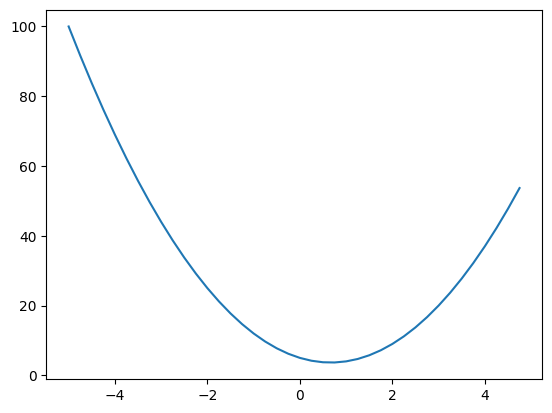

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
ys
plt.plot(xs,ys)

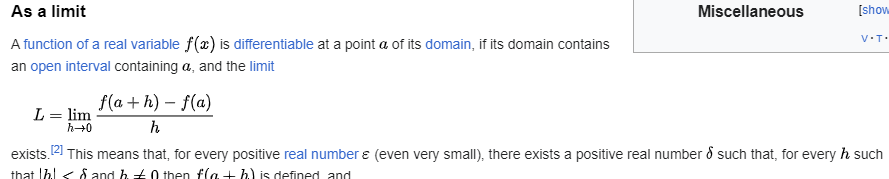

In [5]:
# Computing the derivative

h = 0.00000000001
x = -3.0
(f(x+h) - f(x))/h # This is the slope

-21.999824184604222

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h
d2 = a*b+c

print(d1)
print(d2)
print('slope',(d2-d1)/h)# increase

4.0
3.999699999999999
slope -3.000000000010772


In [46]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='',label=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
      out = Value(t, (self,), 'tanh')

      def _backward():
        self.grad += (1 - t**2) * out.grad
      out._backward = _backward

      return out

    def exp(self):
      x = self.data
      out = Value(math.exp(x),(self, ),'exp')

      def _backward():
        self.grad = out.data * out.grad
      out._backward = _backward
      return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [39]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
print(a+b)
print(a*b)
e = a+b
e.label = 'e'
d = e + c
d.label = 'd'
d
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'

Value(data=-1.0, grad=0)
Value(data=-6.0, grad=0)


Now we need to visualize this operation graphically

In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(),set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})

  nodes,edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name= uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label=n._op)
      #and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1,n2 in edges:
    #connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

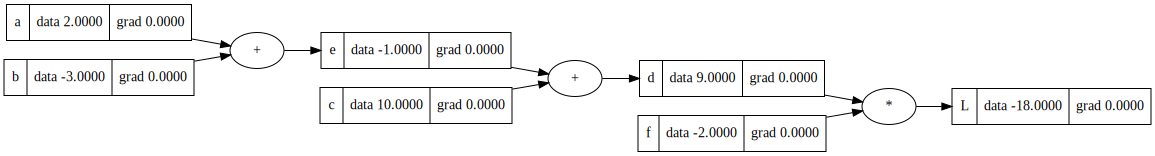

In [11]:
draw_dot(L)

## MANUAL BACKPROPAGATION

L = d * f

dL/dd = f

(f(x+h) - f(x))/h

((d+h)*f - d*f)/h

(d*f + h*f - d*f)/h

(h*f)/h = f

dd / dc = 1.0

dd / de = 1.0

d = c + e

WANT:

dL / dc = (dL / dd) * (dd / dc)

KNOW:

dL / dd

dd / dc

dL / de = -2.0

e = a * b

de / da = ? b

CHAIN RULE:
dL / da = (dL / de) * (de / da)

dL / da = (-2.0) * (-3.0) = 6.0


In [12]:
f.grad = 4.0
d.grad = -2
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -2.0 * 2.0

In [13]:
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  L2 = L.data

  return ((L2-L1)/h)

lol()

-3.9999999999995595

## FORWARD PASS (Increasing the value of L by adding the gradient with step size)

In [14]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b
d = e+c
L = d*f

print(L.data)

-7.286496


TANh function

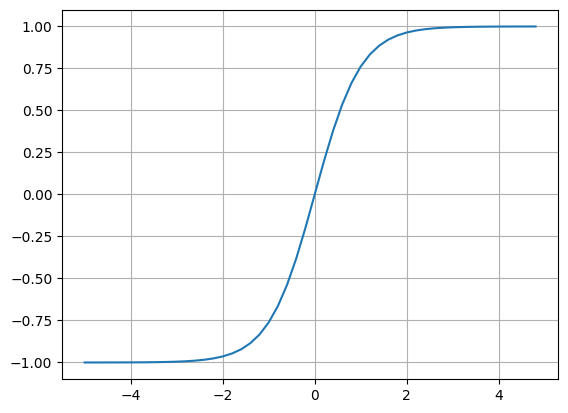

In [15]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)))
plt.grid()

# Working of a Neuron

In [47]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
# Activation function
o = n.tanh()
o.label = 'o'

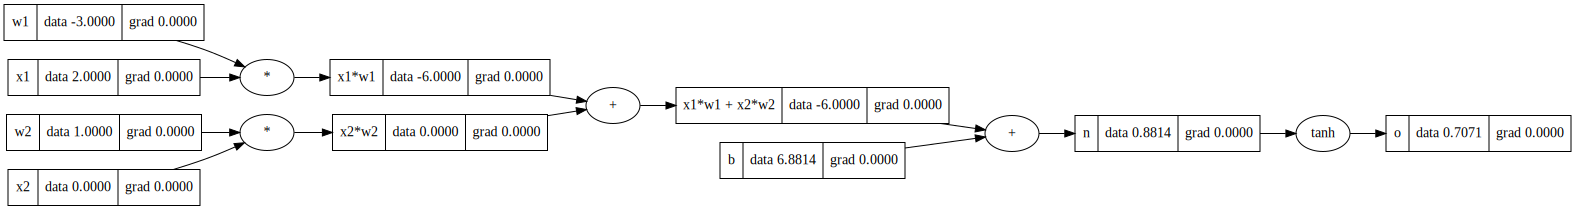

In [48]:
draw_dot(o)

### Backpropagation

In [18]:
o.backward()

In [19]:
o.grad = 1.0

In [20]:
o._backward()

In [21]:
n._backward()

In [22]:
x1w1x2w2._backward()

In [23]:
x1w1._backward()
x2w2._backward()

In [24]:
o.grad = 1.0
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [25]:
1 - o.data**2

0.4999999999999999

In [26]:
# o = tanh(n)
# do/dn = 1 - o**2

## TopoGraphical Sorting

In [27]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  visited.add(v)
  for child in v._prev:
    build_topo(child)
  topo.append(v)
build_topo(o)
print(topo)

for node in reversed(topo):
  node._backward()

[Value(data=-3.0), Value(data=2.0), Value(data=-6.0), Value(data=0.0), Value(data=1.0), Value(data=0.0), Value(data=-6.0), Value(data=6.881373587019543), Value(data=0.8813735870195432), Value(data=0.7071067811865476)]


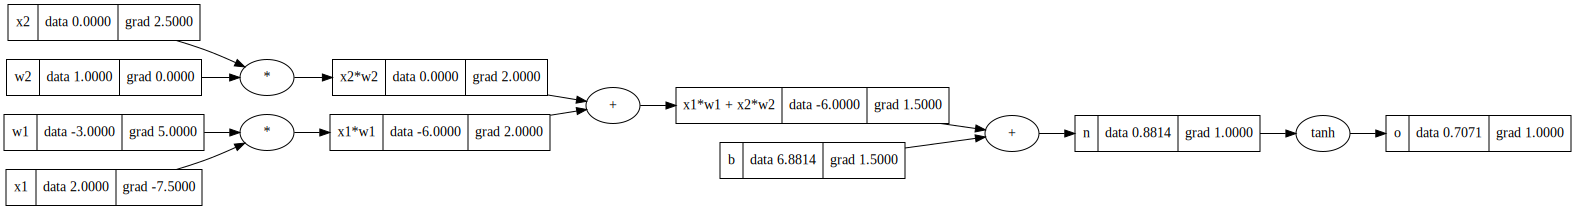

In [28]:
draw_dot(o)

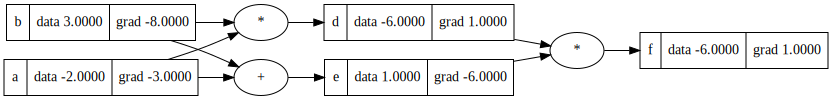

In [29]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b
d.label = 'd'
e = a+b
e.label = 'e'
f = d * e
f.label = 'f'

f.backward()
draw_dot(f)

In [30]:
a = Value(2.0)
a + 2

Value(data=4.0)

In [31]:
print(a * 3 )# Now this works
#But for 3 * a to work, we need to define _rmul_
print(3*a)

Value(data=6.0)
Value(data=6.0)


In [49]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
# Activation function
o = n.tanh()
o.label = 'o'
o.backward()

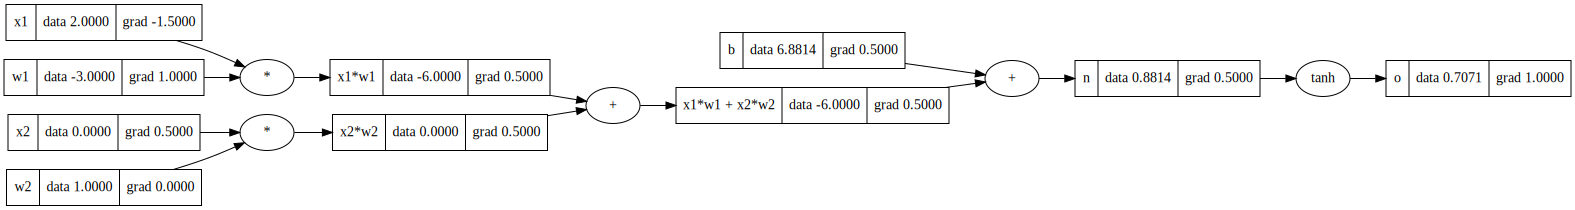

In [50]:
draw_dot(o)

In [44]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b
n.label = 'n'
# ------------------
# Activation function
e = (2*n).exp()
o = (e - 1)/(e + 1)
# -----------------
o.label = 'o'
o.backward()

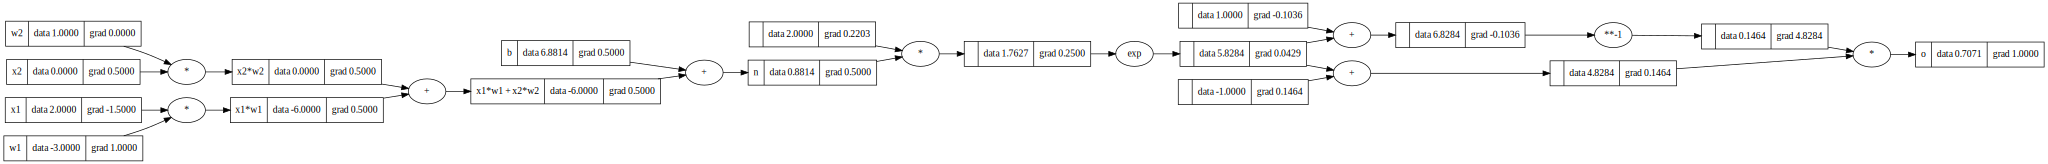

In [45]:
draw_dot(o)